In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import sklearn
print(sklearn.__version__)
from sklearn import preprocessing

import xgboost as xgb
from xgboost import plot_importance
import lightgbm
from lightgbm import LGBMClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


0.23.2


In [3]:
data_df = pd.read_csv("/Users/kimdongkyu/Desktop/인공지능 프로젝트/피파 프로젝트/players_20분류.csv",header=0)
data_df.head(3)

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,...,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,...,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,...,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,...,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3


In [4]:
def format_features(df):
    features = ['team_position']
    for feature in features:
        le=preprocessing.LabelEncoder()
        le=le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

In [5]:
data_df = data_df.dropna(subset=['pace'])
data_df = data_df.dropna(subset=['team_position'])
positionsub = data_df[data_df['team_position']=='SUB'].index
data_df = data_df.drop(positionsub,inplace=False)

In [6]:
x_data = data_df[['preferred_foot','weak_foot','skill_moves','height_cm','weight_kg',"attacking_crossing",'attacking_finishing','attacking_heading_accuracy','attacking_short_passing','attacking_volleys','skill_dribbling','skill_curve','skill_fk_accuracy','skill_long_passing','skill_ball_control','movement_acceleration','movement_sprint_speed','movement_agility','movement_reactions','movement_balance','power_shot_power','power_jumping','power_stamina','power_strength','power_long_shots','mentality_aggression','mentality_interceptions','mentality_vision','mentality_penalties','mentality_composure','defending_marking','defending_standing_tackle','defending_sliding_tackle']]
y_data = data_df[['team_position']]
print(y_data)
y_data = format_features(y_data)

feature = ['preferred_foot']
le=preprocessing.LabelEncoder()
le=le.fit(x_data[feature])
x_data[feature] = le.transform(x_data[feature])

      team_position
0                FW
1                FW
2                AM
4                FW
5                CM
...             ...
18149            CM
18153            WB
18155            CB
18182            WB
18232            WM

[6598 rows x 1 columns]


In [7]:
# **VotingClassifier로 개별모델은 로지스틱 회귀와 KNN을 보팅방식으로 결합하고 성능 비교**

In [9]:
# 개별 모델은 로지스틱 회귀와 KNN 임. 
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기 
vo_clf = VotingClassifier( estimators=[('LR',lr_clf),('KNN',knn_clf)] , voting='soft' )

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, 
                                                    test_size=0.2 , random_state= 156)

# VotingClassifier 학습/예측/평가. 
vo_clf.fit(X_train , y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))


# 개별 모델의 학습/예측/평가.
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train , y_train)
    pred = classifier.predict(X_test)
    class_name= classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test , pred)))


Voting 분류기 정확도: 0.6818
LogisticRegression 정확도: 0.6894
KNeighborsClassifier 정확도: 0.6402


In [10]:
# **학습/테스트 데이터로 분리하고 랜덤 포레스트로 학습/예측/평가**

In [11]:
# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train , y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.6682


In [12]:
# **GridSearchCV 로 교차검증 및 하이퍼 파라미터 튜닝**

In [13]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[300],
    'max_depth' : [6, 8, 10, 12], 
    'min_samples_leaf' : [8, 12, 18 ],
    'min_samples_split' : [8, 16, 20]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=5, n_jobs=-1 )
grid_cv.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))


최적 하이퍼 파라미터:
 {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 300}
최고 예측 정확도: 0.6652


In [14]:
# **튜닝된 하이퍼 파라미터로 재 학습 및 예측/평가**

In [15]:
rf_clf1 = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=8,                                  min_samples_split=8, random_state=0)
rf_clf1.fit(X_train , y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

예측 정확도: 0.6614


In [16]:
# **개별 feature들의 중요도 시각화**

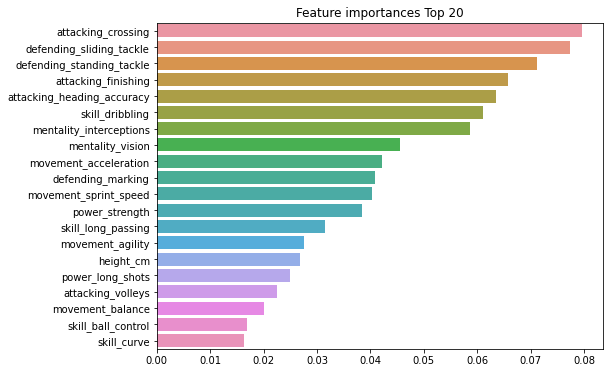

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()


In [18]:
lgbm_wrapper = LGBMClassifier(n_estimators=400)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능. 
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", 
                 eval_set=evals, verbose=True)
lgbm_preds = lgbm_wrapper.predict(X_test)
lgbm_accuracy = accuracy_score(y_test, lgbm_preds)
print('LightGBM 정확도: {0:.4f}'.format(lgbm_accuracy))


[1]	valid_0's multi_logloss: 1.85611
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 1.74653
[3]	valid_0's multi_logloss: 1.65687
[4]	valid_0's multi_logloss: 1.58123
[5]	valid_0's multi_logloss: 1.51343
[6]	valid_0's multi_logloss: 1.45325
[7]	valid_0's multi_logloss: 1.40118
[8]	valid_0's multi_logloss: 1.35631
[9]	valid_0's multi_logloss: 1.31626
[10]	valid_0's multi_logloss: 1.27893
[11]	valid_0's multi_logloss: 1.24499
[12]	valid_0's multi_logloss: 1.21404
[13]	valid_0's multi_logloss: 1.18824
[14]	valid_0's multi_logloss: 1.1656
[15]	valid_0's multi_logloss: 1.14408
[16]	valid_0's multi_logloss: 1.12498
[17]	valid_0's multi_logloss: 1.10662
[18]	valid_0's multi_logloss: 1.08992
[19]	valid_0's multi_logloss: 1.07504
[20]	valid_0's multi_logloss: 1.06045
[21]	valid_0's multi_logloss: 1.04831
[22]	valid_0's multi_logloss: 1.03745
[23]	valid_0's multi_logloss: 1.02572
[24]	valid_0's multi_logloss: 1.0152
[25]	valid_0's multi_logloss: 1.0056


In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred,average='weighted')
    recall = recall_score(y_test , pred,average='weighted')
    f1 = f1_score(y_test,pred,average='weighted')
    ##roc_auc = roc_auc_score(y_test, pred,average='micro',multi_class='ovo')
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},F1: {3:.4f}'.format(accuracy, precision, recall, f1))


In [20]:
get_clf_eval(y_test, lgbm_preds)

오차 행렬
[[ 14   1  22   1   5   5   3  33]
 [  0 254   1   8   0   0  14   0]
 [  6  11 106  49   0   5   7  14]
 [  2  10  52  63   0   0  14   0]
 [  2   0   8   0  10  14   0  32]
 [  3   0   2   0   4 127   0  15]
 [  0  10   5   0   1   0 222   9]
 [ 13   0  15   0   6  11  20  91]]
정확도: 0.6720, 정밀도: 0.6523, 재현율: 0.6720,F1: 0.6556


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

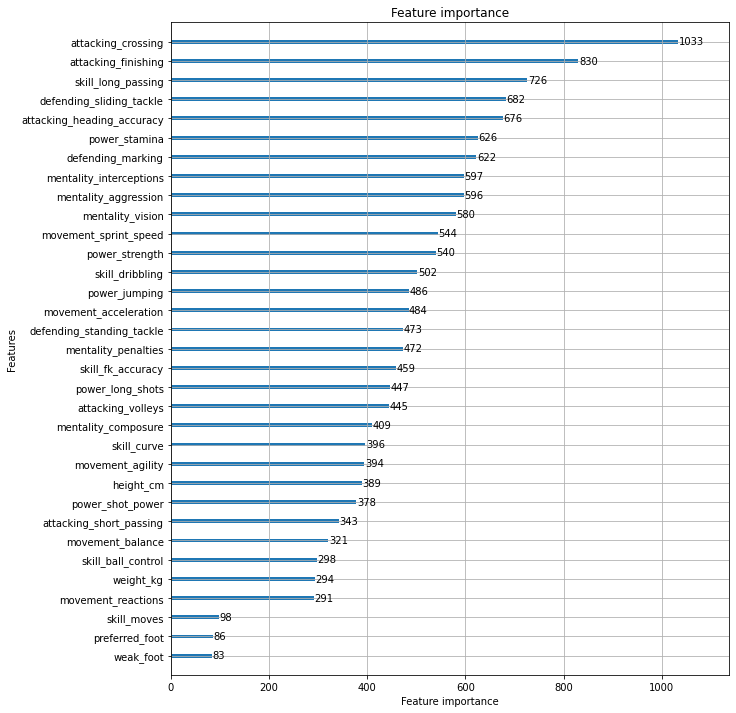

In [21]:
# plot_importance( )를 이용하여 feature 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)

In [22]:
y_test

,team_position
1913,1
14650,6
12768,2
4806,2
4085,2
...,...
8439,1
8814,2
1555,5
4095,4


In [23]:
# 개별 ML 모델을 위한 Classifier 생성.
knn_clf  = KNeighborsClassifier(n_neighbors=8)
rf_clf = RandomForestClassifier(n_estimators=500, random_state=0)
gb_clf = GradientBoostingClassifier(n_estimators=500,random_state=0)

# 최종 Stacking 모델을 위한 Classifier생성. 
lr_final = LogisticRegression()

In [24]:
# 개별 모델들을 학습. 
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train , y_train)
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=500, random_state=0)

In [25]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 셋을 생성하고 개별 모델의 정확도 측정. 
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
gb_pred = gb_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('gbm 정확도 : {0:.4f}'.format(accuracy_score(y_test,gb_pred)))

KNN 정확도: 0.6402
랜덤 포레스트 정확도: 0.6705
gbm 정확도 : 0.6508


In [26]:
pred = np.array([knn_pred, rf_pred,lgbm_preds])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦. 
pred = np.transpose(pred)
print(pred.shape)


(3, 1320)
(1320, 3)


In [27]:
lgbm_wrapper = LGBMClassifier(n_estimators=800)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능. 
lgbm_wrapper.fit(pred, y_test,verbose=True)
lgbm_preds = lgbm_wrapper.predict(pred)
lgbm_accuracy = accuracy_score(y_test, lgbm_preds)
print('최종 정확도: {0:.4f}'.format(lgbm_accuracy))

최종 정확도: 0.7205


In [28]:
get_clf_eval(y_test, lgbm_preds)

오차 행렬
[[ 18   1  17   1   5   5   3  34]
 [  0 260   1   2   0   0  14   0]
 [  6  12 126  35   0   4   3  12]
 [  1  11  52  63   0   0  13   1]
 [  1   0   5   0  17  13   0  30]
 [  0   0   1   0   2 132   0  16]
 [  3  10   5   0   0   0 222   7]
 [  4   0  10   0   5   9  15 113]]
정확도: 0.7205, 정밀도: 0.7125, 재현율: 0.7205,F1: 0.7045


In [29]:
X_train_arr = np.array(X_train)
y_train_arr = np.array(y_train)
X_test_arr = np.array(X_test)

In [30]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean


In [31]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train_arr, y_train_arr, X_test_arr, 10)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train_arr, y_train_arr, X_test_arr, 10)
gb_train, gb_test = get_stacking_base_datasets(gb_clf, X_train_arr, y_train_arr, X_test_arr,  10)

KNeighborsClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
	 폴드 세트:  7  시작 
	 폴드 세트:  8  시작 
	 폴드 세트:  9  시작 
RandomForestClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
	 폴드 세트:  7  시작 
	 폴드 세트:  8  시작 
	 폴드 세트:  9  시작 
GradientBoostingClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
	 폴드 세트:  7  시작 
	 폴드 세트:  8  시작 
	 폴드 세트:  9  시작 


In [32]:
Stack_final_X_train = np.concatenate((knn_train, rf_train,gb_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test,gb_test), axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)


원본 학습 피처 데이터 Shape: (5278, 33) 원본 테스트 피처 Shape: (1320, 33)
스태킹 학습 피처 데이터 Shape: (5278, 3) 스태킹 테스트 피처 데이터 Shape: (1320, 3)


In [33]:
lgbm_wrapper = LGBMClassifier(n_estimators=800)
lgbm_wrapper.fit(Stack_final_X_train, y_train,verbose=True)
lgbm_preds = lgbm_wrapper.predict(Stack_final_X_test)
lgbm_accuracy = accuracy_score(y_test, lgbm_preds)
print('최종 정확도: {0:.4f}'.format(lgbm_accuracy))

최종 정확도: 0.6288
